##1. **Introduction**
Credit card fraud is a widespread issue that occurs globally every day. However, credit card companies have made notable advancements in detecting and preventing fraudulent transactions to safeguard their customers. This dataset contains credit card transaction data from Europe, recorded over two days in September 2013.

The objective of this notebook is to identify fraudulent transactions and predict when they may occur.

##2. **Importing Libraries and Data**

In [4]:
# Importing essential libraries for data manipulation, machine learning, and visualization
import pandas as pd  # For data manipulation and loading datasets
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For advanced data visualization

from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler  # For scaling features
from sklearn.linear_model import LogisticRegression  # For Logistic Regression model
from sklearn.tree import DecisionTreeClassifier  # For Decision Tree model
from sklearn.ensemble import RandomForestClassifier  # For Random Forest model
from sklearn.metrics import classification_report, confusion_matrix  # For evaluating model performance
from imblearn.over_sampling import SMOTE  # For handling class imbalance using SMOTE

In [7]:
df_train_original = pd.read_csv('/content/fraudTrain.csv') #Loading the training data
df_train_original.drop(df_train_original.columns[0], axis=1, inplace=True) #Drop the first column of the DataFrame

df_test_original = pd.read_csv('/content/fraudTest.csv') #Loading the testing data
df_test_original.drop(df_test_original.columns[0], axis=1, inplace=True) #Drop the first column of the DataFrame

In [22]:
# Define the proportion of the sample size we want
sample_size = 0.15

# Performing stratified sampling
df, _ = train_test_split(df_train_original, test_size=1-sample_size, stratify=df_train_original['is_fraud'], random_state=42)

# Displaying the sampled DataFrame
df.shape

(194501, 22)

##3. **EDA (Exploratory Data Analysis)**

###3.1 Handling Missing Values

In [16]:
# Check for missing values
print(df_train_original.isnull().sum())
print(df_test_original.isnull().sum())

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long           

We can see that there are no missing values in the datasets.

###3.2 Data Summary and Data Balance Check

In [18]:
# Summary statistics of the training data
print(df_train_original.describe())

             cc_num           amt           zip           lat          long  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   4.171920e+17  7.035104e+01  4.880067e+04  3.853762e+01 -9.022634e+01   
std    1.308806e+18  1.603160e+02  2.689322e+04  5.075808e+00  1.375908e+01   
min    6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01 -1.656723e+02   
25%    1.800429e+14  9.650000e+00  2.623700e+04  3.462050e+01 -9.679800e+01   
50%    3.521417e+15  4.752000e+01  4.817400e+04  3.935430e+01 -8.747690e+01   
75%    4.642255e+15  8.314000e+01  7.204200e+04  4.194040e+01 -8.015800e+01   
max    4.992346e+18  2.894890e+04  9.978300e+04  6.669330e+01 -6.795030e+01   

           city_pop     unix_time     merch_lat    merch_long      is_fraud  
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  
mean   8.882444e+04  1.349244e+09  3.853734e+01 -9.022646e+01  5.788652e-03  
std    3.019564e+05  1.284128e+07  5.109788e+00  1.377

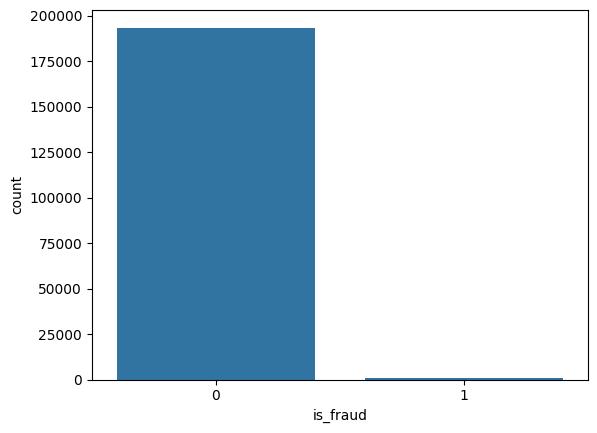

In [23]:
# Check the distribution of the target variable (assuming 'Class' is the target column)
sns.countplot(x='is_fraud', data=df)
plt.show()

Text(0.5, 1.0, 'Percentage of Fraudulent vs Non-fraudulent transactions')

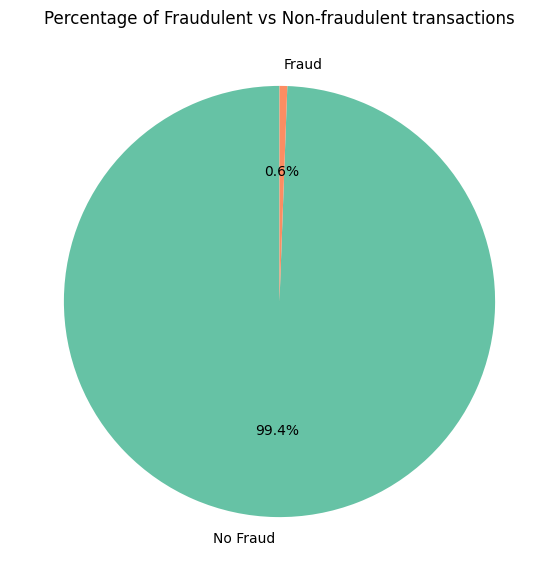

In [34]:
#Data Balance Check
df['is_fraud_cat'] = df['is_fraud'].apply(lambda x: "Fraud" if x==1 else "No Fraud")

is_fraud_values = df['is_fraud_cat'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(is_fraud_values, labels=is_fraud_values.index, autopct='%1.1f%%', startangle=90, colors = sns.color_palette("Set2", n_colors=len(is_fraud_values)))
plt.title('Percentage of Fraudulent vs Non-fraudulent transactions')

From the diagrams we see that the data exhibits a significant class imbalance, indicating a strong skew in the distribution of the classes.

###3.3 Fraud by Transaction Categories

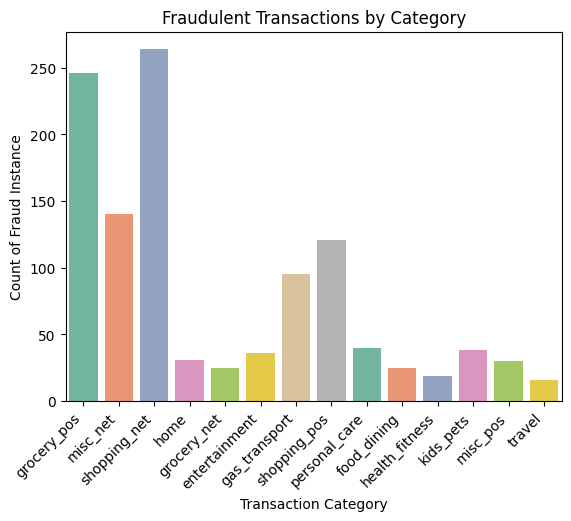

<Figure size 1000x2400 with 0 Axes>

In [39]:
sns.countplot(x="category", data=df[df['is_fraud_cat']=="Fraud"], palette="Set2", hue = 'category')

plt.title('Fraudulent Transactions by Category')
plt.xlabel('Transaction Category')
plt.ylabel('Count of Fraud Instance')
plt.xticks(rotation=45, ha = 'right')
plt.figure(figsize=(10, 24))
plt.show()

###3.4 Fraud by Jobs

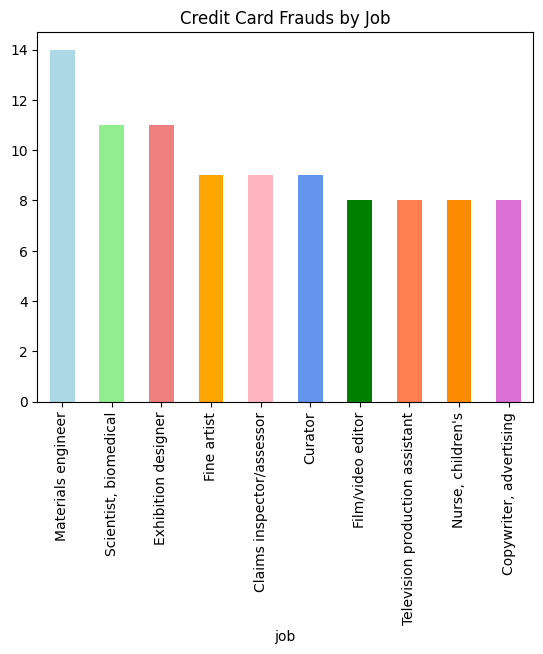

<Figure size 1000x2400 with 0 Axes>

In [51]:
df[df['is_fraud_cat']=="Fraud"]["job"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar",x='Jobs', y=df['is_fraud_cat']=="Fraud", color=['lightblue', 'lightgreen', 'lightcoral', 'orange', 'lightpink','cornflowerblue', 'green', 'coral', 'darkorange', 'orchid'])
plt.title("Credit Card Frauds by Job")
plt.figure(figsize=(10, 24))
plt.show()

##4. **Data Pre-processing**

###4.1. Handling Duplicate Values

In [53]:
# Create a copy of the original DataFrame 'df' to avoid modifying the original data
df2 = df.copy()

# Remove duplicate rows from 'df2', keeping only unique rows
# The 'inplace=True' argument ensures the changes are made directly to 'df2'
df2.drop_duplicates(inplace=True)

# Print a message confirming that the duplicates have been dropped
print("Duplicated Values Dropped")

Duplicated Values Dropped


###4.2. Transforming Variables
Transforming the gender variable to be binary

In [54]:
def gender_transform(x):
    if x=='F':
        return 1
    if x=='M':
        return 0
df2['gender'] = df2['gender'].transform(gender_transform)

###4.3. Dummy Variables
We will examine the categorical data and the number of unique values in each to decide which ones to keep for creating dummy variables.

In [56]:
df3 = df2.drop(['unix_time','trans_date_trans_time','cc_num','trans_num','street','dob','city','merchant','job','last','first','state','is_fraud_cat'],axis = 1)

In [57]:
# Convert categorical columns to dummy variables (binary columns) and store them in 'df3_dummies'
df3_dummies = pd.get_dummies(df3.select_dtypes('object'), dtype=int)

# Drop the original categorical columns and concatenate the dummy variables to 'df3'
df4 = pd.concat([df3.drop(df3.select_dtypes('object').columns, axis=1), df3_dummies], axis=1)

# Print the shape of the new DataFrame to check the number of rows and columns
print(df4.shape)

# Display the first few rows of the new DataFrame to inspect the result
df4.head()

(194501, 23)


,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,category_entertainment,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
398918,55.05,0,37849,36.0435,-84.0400,25459,36.175640,-84.646341,0,0,...,0,0,0,1,0,0,0,0,0,0
655541,3.03,0,7208,40.6747,-74.2239,124967,40.939505,-74.256242,0,0,...,0,0,0,0,0,1,0,0,0,0
911788,139.01,1,45342,39.6321,-84.2675,36784,39.822635,-84.105583,0,1,...,0,0,0,0,0,0,0,0,0,0
86389,55.74,1,29032,34.3424,-80.5000,4424,34.962050,-80.168628,0,0,...,0,0,0,0,0,0,0,0,0,0
289156,93.78,1,73559,34.7032,-98.9591,540,34.068722,-98.940711,0,0,...,1,0,0,0,0,0,0,0,0,0


###4.4 Stratified Train/Test split
We need to generate a training / validation dataset split that will keep the same percentages of classes in each split.

In [58]:
X = df4.reset_index(drop='index').drop('is_fraud', axis=1)

y = df4.reset_index(drop='index')['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

##5. **Baseline Models (no imbalance resolving)**
We will build some baseline models (Logistic regression, Decision Trees and Random Forests model) so we can have a reference in how the model performs if we left the data as it is.

###5.1. **Logistic Regression**

In [59]:
#Import Required Libraries

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [60]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [65]:
# Make predictions on the test set
y_pred_base = log_reg.predict(X_test)

In [66]:
# Calculate and print performance metrics
accuracy = accuracy_score(y_test, y_pred_base)
precision = precision_score(y_test, y_pred_base)
recall = recall_score(y_test, y_pred_base)
f1 = f1_score(y_test, y_pred_base)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_base)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_base))

Accuracy: 0.99
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
 [[57988    25]
 [  338     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     58013
           1       0.00      0.00      0.00       338

    accuracy                           0.99     58351
   macro avg       0.50      0.50      0.50     58351
weighted avg       0.99      0.99      0.99     58351



In [67]:
#creating an overall performance table
cm = confusion_matrix(y_test, y_pred_base)

lr_baseline_Recall = recall_score(y_test, y_pred_base)
lr_baseline_Precision = precision_score(y_test, y_pred_base)
lr_baseline_f1 = f1_score(y_test, y_pred_base)
lr_baseline_accuracy = accuracy_score(y_test, y_pred_base)

ndf = [(lr_baseline_Recall, lr_baseline_Precision, lr_baseline_f1, lr_baseline_accuracy)]

lr_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
lr_score.insert(0, 'Logistic Regression performed with', 'Original (Imbalanced Dataset)')
lr_score

,Logistic Regression performed with,Recall,Precision,F1 Score,Accuracy
0,Original (Imbalanced Dataset),0.0,0.0,0.0,0.993779


Note: Recall, precision, and F1-score are currently 0. This issue likely arises due to the class imbalance in the dataset, where the model predicts only the majority class (non-fraudulent transactions).


###5.2. **Decision Tree**

In [68]:
#Import Required Libraries

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [69]:
# Initialize the Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [70]:
# Predict the labels for the test set
y_pred = dt_model.predict(X_test)

In [71]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58013
           1       0.64      0.63      0.63       338

    accuracy                           1.00     58351
   macro avg       0.82      0.82      0.82     58351
weighted avg       1.00      1.00      1.00     58351

Confusion Matrix:
[[57890   123]
 [  124   214]]


In [80]:
#creating an overall performance table
cm = confusion_matrix(y_test, y_pred)

dt_baseline_Recall = recall_score(y_test, y_pred)
dt_baseline_Precision = precision_score(y_test, y_pred)
dt_baseline_f1 = f1_score(y_test, y_pred)
dt_baseline_accuracy = accuracy_score(y_test, y_pred)

ndf = [(dt_baseline_Recall, dt_baseline_Precision, dt_baseline_f1, dt_baseline_accuracy)]

dt_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
dt_score.insert(0, 'Decision Tree performed with', 'Original (Imbalanced Dataset)')
dt_score

,Decision Tree performed with,Recall,Precision,F1 Score,Accuracy
0,Original (Imbalanced Dataset),0.633136,0.635015,0.634074,0.995767


###5.3. **Random Forest**

In [75]:
#Import the required libraries

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [76]:
# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [77]:
# Predict the labels for the test set
y_pred1 = rf_model.predict(X_test)

In [78]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred1))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred1))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58013
           1       0.87      0.57      0.69       338

    accuracy                           1.00     58351
   macro avg       0.93      0.78      0.84     58351
weighted avg       1.00      1.00      1.00     58351

Confusion Matrix:
[[57984    29]
 [  146   192]]


In [108]:
#creating an overall performance table
cm = confusion_matrix(y_test, y_pred1)

rf_baseline_Recall = recall_score(y_test, y_pred1)
rf_baseline_Precision = precision_score(y_test, y_pred1)
rf_baseline_f1 = f1_score(y_test, y_pred1)
rf_baseline_accuracy = accuracy_score(y_test, y_pred1)

ndf = [(rf_baseline_Recall, rf_baseline_Precision, rf_baseline_f1, rf_baseline_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest performed with', 'Original (Imbalanced Dataset)')
rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Original (Imbalanced Dataset),0.568047,0.868778,0.686941,0.997001


Here, we are getting higher Precision, F1 Score, and Accuracy. So we can use the Random Forest model for fraud detection as this model can handle Linear as well as Non-linear relations efficiently.

In case of the lower Recall value, we have to balance the dataset using undersampling or SMOTE to get a higher value.

##6. **Handling the Imbalanced Data**

###6.1. Undersampling

In [83]:
#Initialize the model

from imblearn.under_sampling import RandomUnderSampler
# defining undersampling method
rus = RandomUnderSampler(random_state=42)

rf_undersample = RandomForestClassifier(n_estimators=200)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [85]:
#Fitting the model

rf_undersample.fit(X_train_undersample, y_train_undersample)
y_pred_undersample = rf_undersample.predict(X_test)

In [86]:
#Performance & Accuracy

print("Performance with Random Undersampling:")
print(classification_report(y_test, y_pred_undersample))

Performance with Random Undersampling:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     58013
           1       0.12      0.93      0.21       338

    accuracy                           0.96     58351
   macro avg       0.56      0.95      0.59     58351
weighted avg       0.99      0.96      0.97     58351



In [91]:
#creating an overall performance table
cm = confusion_matrix(y_test, y_pred_undersample)

undersample_rf_Recall = recall_score(y_test, y_pred_undersample)
undersample_rf_Precision = precision_score(y_test, y_pred_undersample)
undersample_rf_f1 = f1_score(y_test, y_pred_undersample)
undersample_rf_accuracy = accuracy_score(y_test, y_pred_undersample)

ndf_over = [(undersample_rf_Recall, undersample_rf_Precision, undersample_rf_f1, undersample_rf_accuracy)]

undersample_rf_score = pd.DataFrame(data = ndf_over, columns=['Recall','Precision','F1 Score', 'Accuracy'])
undersample_rf_score.insert(0, 'Random Forest performed with', 'Undersampling')
undersample_rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Undersampling,0.934911,0.117428,0.20865,0.958921


###6.2. SMOTE (Synthetic Minority Over-sampling Technique)

In [92]:
#Initialize the model

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
rf_smote = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [93]:
#Fitting the model

rf_smote.fit(X_train_smote,y_train_smote)
y_pred_smote = rf_smote.predict(X_test)

In [94]:
#Performance and Accuracy

print("Performance with SMOTE:")
print(classification_report(y_test, y_pred_smote))

Performance with SMOTE:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     58013
           1       0.12      0.76      0.21       338

    accuracy                           0.97     58351
   macro avg       0.56      0.86      0.60     58351
weighted avg       0.99      0.97      0.98     58351



In [96]:
#creating an overall performance table
cm_smote = confusion_matrix(y_test, y_pred_smote)
rf_smote_Recall = recall_score(y_test, y_pred_smote)
rf_smote_Precision = precision_score(y_test, y_pred_smote)
rf_smote_f1 = f1_score(y_test, y_pred_smote)
rf_smote_accuracy = accuracy_score(y_test, y_pred_smote)

ndf = [(rf_smote_Recall, rf_smote_Precision, rf_smote_f1, rf_smote_accuracy)]

rf_smote_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_smote_score.insert(0, 'Random Forest performed with', 'SMOTE')
rf_smote_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,SMOTE,0.760355,0.122556,0.211088,0.967079


###6.3. ***Performance Summary***

In [109]:
#creating an overall performance table
rf_sampling_scores = pd.concat([rf_score, undersample_rf_score, rf_smote_score], axis=0)
rf_sampling_scores

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Original (Imbalanced Dataset),0.568047,0.868778,0.686941,0.997001
0,Undersampling,0.934911,0.117428,0.208650,0.958921
0,SMOTE,0.760355,0.122556,0.211088,0.967079


 For our fraud detection model, we chose **undersampling** despite its lower precision (0.117) because it achieves the highest recall of 0.934, meaning it catches 93.4% of fraud cases. While this creates a more "paranoid" model that may generate more false alarms, in fraud detection, missing fraudulent transactions (false negatives) is far more costly than having false positives, which can be quickly verified.

 This approach is preferred as the cost of investigating suspicious transactions is minimal compared to the potential losses from undetected fraud.

##7. **Applying the best model**
As mentioned earlier, we will continue with Undersampling

In [118]:
#Showing the accuracy score using SMOTE

accuracy = accuracy_score(y_test, y_pred_undersample)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 95.89%


In [119]:
#Print the predicted and actual class names

# remapping the classes
class_names = {1:'Fraud',0:'No Fraud'}
predicted_classes = [class_names[label] for label in y_pred_undersample]

# Mapping true labels to custom class names
class_map = [class_names[label] for label in y_test]

# Step 10: Print the predicted and actual class names for the first 5 test samples
for i in range(20):
    print(f"Sample {i+1}: True Class: {class_map[i]}, Predicted Class: {predicted_classes[i]}")

Sample 1: True Class: No Fraud, Predicted Class: No Fraud
Sample 2: True Class: No Fraud, Predicted Class: No Fraud
Sample 3: True Class: No Fraud, Predicted Class: No Fraud
Sample 4: True Class: No Fraud, Predicted Class: No Fraud
Sample 5: True Class: No Fraud, Predicted Class: No Fraud
Sample 6: True Class: No Fraud, Predicted Class: No Fraud
Sample 7: True Class: No Fraud, Predicted Class: No Fraud
Sample 8: True Class: No Fraud, Predicted Class: No Fraud
Sample 9: True Class: No Fraud, Predicted Class: No Fraud
Sample 10: True Class: No Fraud, Predicted Class: No Fraud
Sample 11: True Class: No Fraud, Predicted Class: No Fraud
Sample 12: True Class: No Fraud, Predicted Class: No Fraud
Sample 13: True Class: No Fraud, Predicted Class: No Fraud
Sample 14: True Class: No Fraud, Predicted Class: No Fraud
Sample 15: True Class: No Fraud, Predicted Class: No Fraud
Sample 16: True Class: No Fraud, Predicted Class: No Fraud
Sample 17: True Class: No Fraud, Predicted Class: No Fraud
Sample